<a href="https://colab.research.google.com/github/Legendary-Nerd/Unet-Shape-Segmentation/blob/main/U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Shape Dataset Generation for U-Net Segmentation Training

Generates a synthetic dataset of images containing simple geometric shapes (circle, square, triangle) and their corresponding segmentation masks.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

def generate_shapes_dataset(num_samples=500, image_size=128):
    X = []
    Y = []

    for _ in range(num_samples):
        img = np.zeros((image_size, image_size), dtype=np.uint8)
        mask = np.zeros_like(img)

        shape_type = np.random.choice(['circle', 'square', 'triangle'])
        center = (np.random.randint(32, 96), np.random.randint(32, 96))
        size = np.random.randint(20, 40)

        if shape_type == 'circle':
            cv2.circle(img, center, size, 255, -1)
            cv2.circle(mask, center, size, 1, -1)
        elif shape_type == 'square':
            top_left = (center[0]-size, center[1]-size)
            bottom_right = (center[0]+size, center[1]+size)
            cv2.rectangle(img, top_left, bottom_right, 255, -1)
            cv2.rectangle(mask, top_left, bottom_right, 1, -1)
        elif shape_type == 'triangle':
            pt1 = (center[0], center[1]-size)
            pt2 = (center[0]-size, center[1]+size)
            pt3 = (center[0]+size, center[1]+size)
            pts = np.array([pt1, pt2, pt3])
            cv2.drawContours(img, [pts], 0, 255, -1)
            cv2.drawContours(mask, [pts], 0, 1, -1)

        X.append(np.expand_dims(img / 255.0, axis=-1))
        Y.append(np.expand_dims(mask, axis=-1))

    return np.array(X), np.array(Y)

X, Y = generate_shapes_dataset()
print("X shape:", X.shape, "Y shape:", Y.shape)


X shape: (500, 128, 128, 1) Y shape: (500, 128, 128, 1)


Build a Simple U-Net

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(2)(c1)

    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(2)(c2)

    # Bottleneck
    b = Conv2D(128, 3, activation='relu', padding='same')(p2)
    b = Conv2D(128, 3, activation='relu', padding='same')(b)

    # Decoder
    u1 = UpSampling2D(2)(b)
    u1 = concatenate([u1, c2])
    c3 = Conv2D(64, 3, activation='relu', padding='same')(u1)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)

    u2 = UpSampling2D(2)(c3)
    u2 = concatenate([u2, c1])
    c4 = Conv2D(32, 3, activation='relu', padding='same')(u2)
    c4 = Conv2D(32, 3, activation='relu', padding='same')(c4)

    outputs = Conv2D(1, 1, activation='sigmoid')(c4)

    return Model(inputs, outputs)

model = build_unet((128, 128, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 96)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_8[0][0]  

 Total params: 470,977 (1.80 MB)

 Trainable params: 470,977 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

Train Model


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    batch_size=16, epochs=10)


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.9425 - loss: 0.4038 - val_accuracy: 0.9930 - val_loss: 0.0230
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step - accuracy: 0.9953 - loss: 0.0149 - val_accuracy: 0.9980 - val_loss: 0.0076
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 198s 6s/step - accuracy: 0.9986 - loss: 0.0052 - val_accuracy: 0.9989 - val_loss: 0.0031
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 161s 6s/step - accuracy: 0.9989 - loss: 0.0032 - val_accuracy: 0.9994 - val_loss: 0.0024
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step - accuracy: 0.9994 - loss: 0.0021 - val_accuracy: 0.9995 - val_loss: 0.0018
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 203s 6s/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9996 - val_loss: 0.0013
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9997 - val_loss: 9.9548e-04
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 203s 6s/step - accuracy: 0.9997 - loss: 9.4658e-04 - val_accuracy: 0.

Visualize Prediction



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


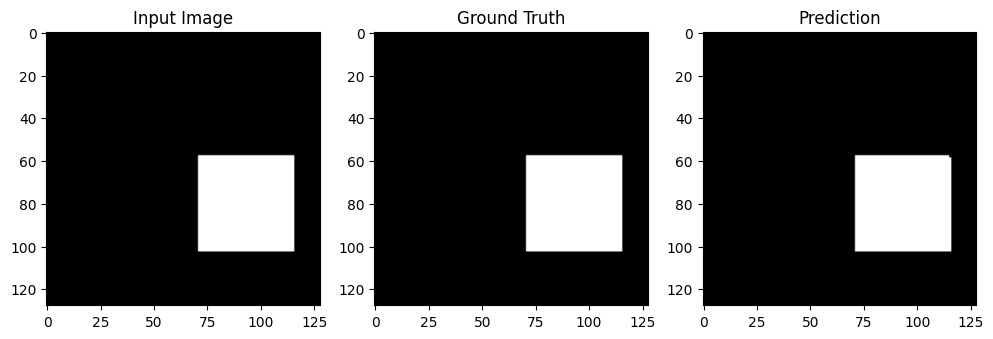

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


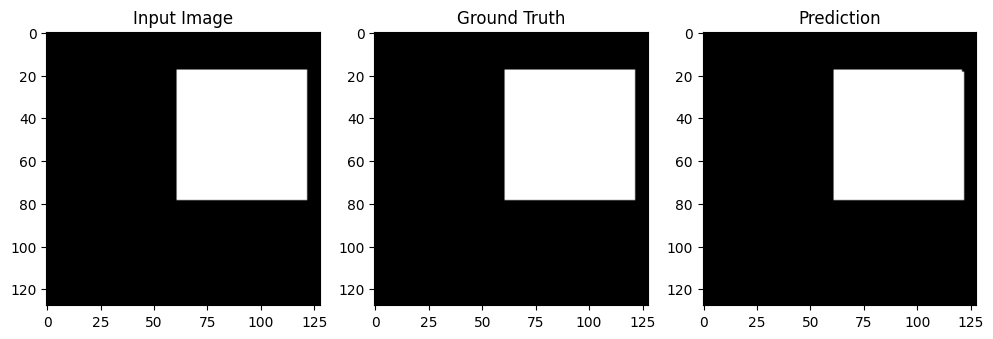

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


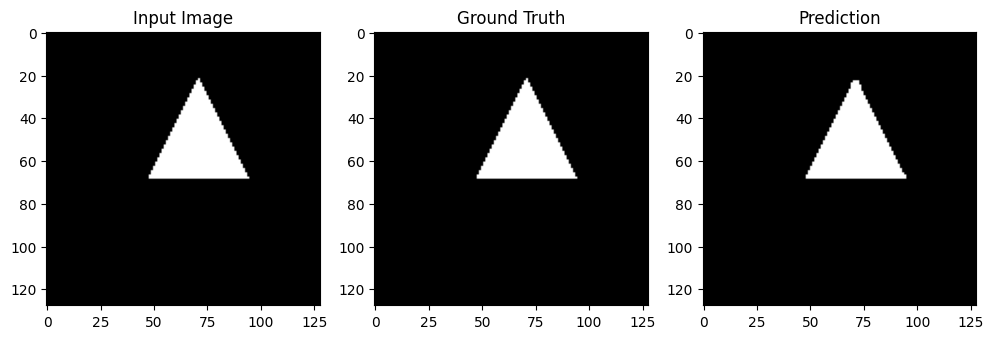

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


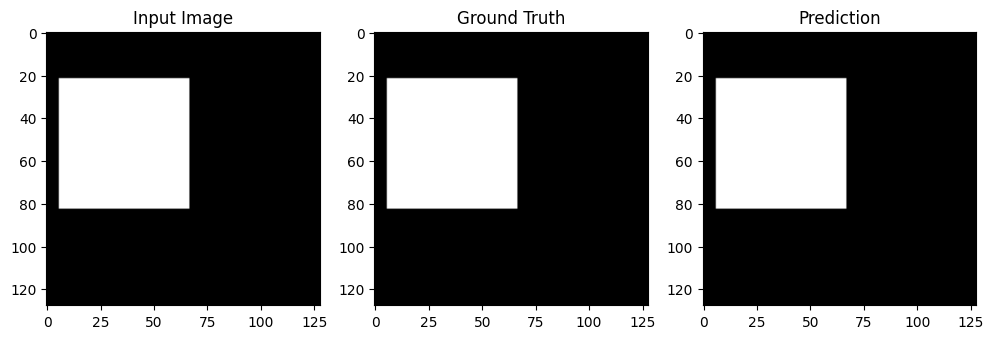

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


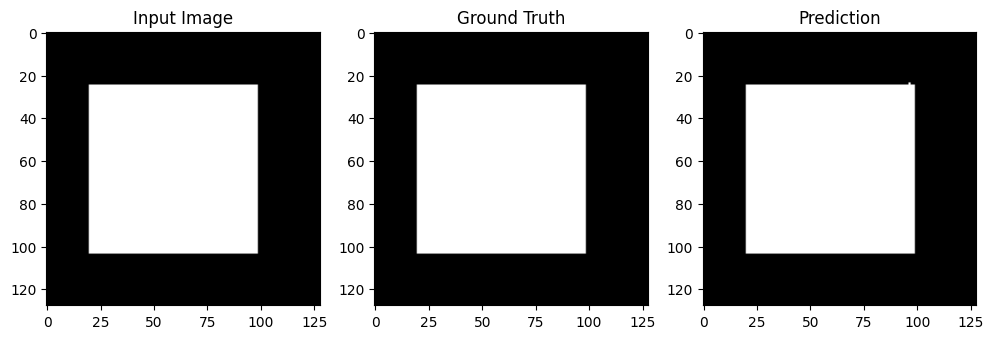

In [5]:
def show_sample(i=0):
    img = X_val[i]
    mask = Y_val[i]
    pred = model.predict(np.expand_dims(img, axis=0))[0]

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Input Image")
    plt.imshow(img[:,:,0], cmap='gray')

    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(mask[:,:,0], cmap='gray')

    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.imshow(pred[:,:,0] > 0.5, cmap='gray')  # thresholded
    plt.show()

for i in range(5):
  show_sample(i)
